# Ford GoBike System Data
### by `Hamid Khodabandehloo`

## Preliminary Wrangling

> The data includs informations about station and trip information of a bike sharing application (primarily, it was in 12 `csv` files with 15 columns and about 250k rows overal). In the `Wrangling.py` file I merged the files and fixed five quality and one tidiness issues. The wrangling process resulted in seperating the data into two tables and removing of about four percent of the data. The trip data includes start, end station id, start time, end time, duration and bike id. Stations data includes name, longitude and latitude of the bike-sharing stations.

In [40]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
# conda install -c conda-forge gmaps
import gmaps
import networkx as nx
from Wrangling import downloadFile , downloadAllFiles, mergeAllFiles, clean
%matplotlib inline

In [2]:
#Download 12 files for each month of 2019 and unzip them
downloadAllFiles()

#Merge all 12 files in All.csv file and remove the rest
mergeAllFiles()

# Clean 4 quality issues and one tidiness issue
clean()

C:\Users\hamid\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2407190 entries, 0 to 2506660
Data columns (total 14 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           int32
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             int32
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
bike_share_for_all_trip    object
dtypes: datetime64[ns](2), float64(4), int32(2), int64(2), object(4)
memory usage: 257.1+ MB


> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [2]:
df_stations = pd.read_csv('stations.csv')
df_stations.head()

,station_id,latitude,longitude,name
0,3,37.786375,-122.404904,Powell St BART Station (Market St at 4th St)
1,4,37.785881,-122.408915,Cyril Magnin St at Ellis St
2,5,37.783899,-122.408445,Powell St BART Station (Market St at 5th St)
3,6,37.804770,-122.403234,The Embarcadero at Sansome St
4,7,37.804562,-122.271738,Frank H Ogawa Plaza


In [3]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 4 columns):
station_id    456 non-null int64
latitude      456 non-null float64
longitude     456 non-null float64
name          456 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 14.4+ KB


In [4]:
df_stations.describe()

,station_id,latitude,longitude
count,456.000000,456.000000,456.000000
mean,247.789474,37.721975,-122.056325
std,142.295327,0.422517,3.175100
min,3.000000,37.309014,-122.495241
25%,128.500000,37.740096,-122.411729
50%,245.500000,37.776382,-122.384696
75%,376.250000,37.803313,-122.253071
max,498.000000,45.510000,-73.570000


In [5]:
df_stations.shape

(456, 4)

In [6]:
df_trips = pd.read_csv('trips.csv', index_col=0, low_memory=False)
df_trips.head()

C:\Users\hamid\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,duration_sec,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,bike_share_for_all_trip
0,80825,2019-01-31 17:57:44.613,2019-02-01 16:24:49.864,229,196,4861,Subscriber,No
1,65900,2019-01-31 20:58:33.886,2019-02-01 15:16:54.173,4,134,5506,Subscriber,No
2,62633,2019-01-31 18:06:52.924,2019-02-01 11:30:46.530,245,157,2717,Customer,No
3,44680,2019-01-31 19:46:09.719,2019-02-01 08:10:50.318,85,53,4557,Customer,No
4,60709,2019-01-31 14:19:01.541,2019-02-01 07:10:51.065,16,28,2100,Customer,No


In [7]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2407190 entries, 0 to 2506660
Data columns (total 8 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           int64
end_station_id             int64
bike_id                    int64
user_type                  object
bike_share_for_all_trip    object
dtypes: int64(4), object(4)
memory usage: 165.3+ MB


In [8]:
df_trips.describe()

,duration_sec,start_station_id,end_station_id,bike_id
count,2.407190e+06,2.407190e+06,2.407190e+06,2.407190e+06
mean,8.040941e+02,1.462486e+02,1.424772e+02,9.290447e+03
std,1.899553e+03,1.221957e+02,1.213281e+02,5.046314e+04
min,6.000000e+01,3.000000e+00,3.000000e+00,4.000000e+00
25%,3.580000e+02,4.700000e+01,4.200000e+01,1.877000e+03
50%,5.690000e+02,1.040000e+02,1.010000e+02,3.727000e+03
75%,8.830000e+02,2.420000e+02,2.390000e+02,7.170000e+03
max,8.623000e+04,4.980000e+02,4.980000e+02,9.984300e+05


In [9]:
df_trips.shape

(2407190, 8)

### What is the structure of your dataset?

> Information about the stations are stored in `df_stations` which includes folowing columns:
><br> **station_id:** Id of the station.
><br> **latitude:** Latitude GPS coordinate.
><br> **longitude:** Longitude GPS coordinate.
><br> **name:** Name of the station.
><br> This table has **4 columns** and **456 rows**.
><br>
><br> Information about trips are stored in df_trips which includes folowing columns:
><br> **duration_sec:** Duration of the trip in seconds.
><br> **start_time:** Start time of the trip.
><br> **end_time:** End time of the trip.
><br> **start_station_id:** The station that trip started from.
><br> **end_station_id:** The station that trip ended in.
><br> **bike_id:** Id of the bike used for the trip.
><br> **user_type:** Type of the user (subscriber or customer – “Subscriber” = Member or “Customer” = Casual)                
> **bike_share_for_all_trip:** If the bike is used for all trip.
><br> This table has **8 columns** and **2407190 rows**.

> These two table can be joined based on `station_id`, `start_station_id` and `end_station_id` columns.



### What is/are the main feature(s) of interest in your dataset?

> It is important to see how people are using bike sharing system. How bike usage change during a day, week, month and year. Which stations are bussier and when. How long people tend to use a bike and how far they go with the bike. How subscibers and casual customers differ in bike usage.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Start and end time and duration of the trip. GPS cordinates (I will need to add UTM cordinates to calculate trip distance). User type and bike id. I will need to add day of the week to the dataset too.

In [10]:
# Add week day of start and end time of the trip to df_trips
df_trips['start_time'] = pd.to_datetime(df_trips['start_time'])
df_trips['end_time'] = pd.to_datetime(df_trips['end_time'])
    
df_trips['start_weekday'] = df_trips['start_time'].dt.dayofweek
df_trips['end_weekday'] = df_trips['end_time'].dt.dayofweek


# Add city to df_stations
df_stations['city'] = ''
df_stations.loc[(df_stations['latitude'] > 37.691495) & (df_stations['latitude'] < 37.825785) & (df_stations['longitude'] < -122.376299) &  (df_stations['longitude'] > -122.533738),['city']] = 'San Francisco'
df_stations.loc[(df_stations['latitude'] > 37.711895) & (df_stations['latitude'] < 37.899914) & (df_stations['longitude'] < -22.141754) &  (df_stations['longitude'] > -122.360498),['city']] = 'Oakland'
df_stations.loc[df_stations['city']=="",['city']] = 'San Jose'

In [11]:
df_trips.head()

,duration_sec,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,bike_share_for_all_trip,start_weekday,end_weekday
0,80825,2019-01-31 17:57:44.613,2019-02-01 16:24:49.864,229,196,4861,Subscriber,No,3,4
1,65900,2019-01-31 20:58:33.886,2019-02-01 15:16:54.173,4,134,5506,Subscriber,No,3,4
2,62633,2019-01-31 18:06:52.924,2019-02-01 11:30:46.530,245,157,2717,Customer,No,3,4
3,44680,2019-01-31 19:46:09.719,2019-02-01 08:10:50.318,85,53,4557,Customer,No,3,4
4,60709,2019-01-31 14:19:01.541,2019-02-01 07:10:51.065,16,28,2100,Customer,No,3,4


## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

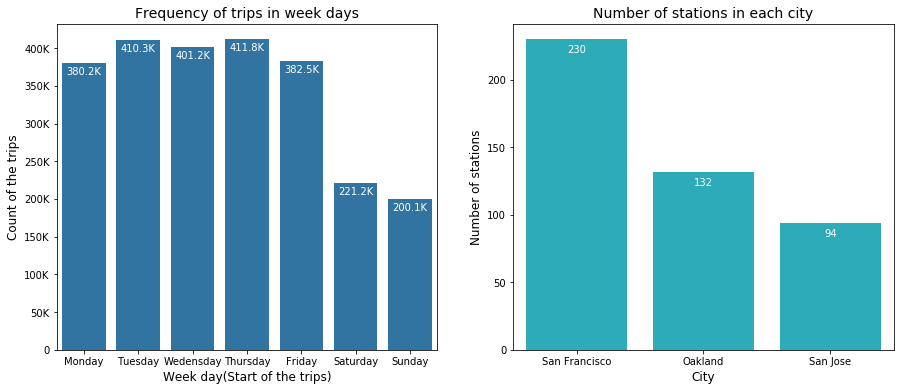

In [12]:
# Trip frequency during weekday and weekends

plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
base_color = sb.color_palette()[0]
sb.countplot(data=df_trips, x = 'start_weekday', color=base_color);
plt.xlabel('Week day(Start of the trips)',fontsize=12)
plt.ylabel('Count of the trips',fontsize=12)
plt.title('Frequency of trips in week days',fontsize=14)
plt.yticks(np.arange(0, 450000, 50000), ['0', '50K', '100K','150K','200K','250K','300K','350K','400K']);
n_points=df_trips.shape[0]

locs, labels = plt.xticks()
for loc, label in zip(locs, labels):
    count = len(df_trips[df_trips['start_weekday'] == int(label.get_text())])
    pct_string = '{:0.1f}K'.format(count/1000)
    plt.text(loc, count-15000, pct_string, ha='center', color='w' )
plt.xticks([0,1,2,3,4,5,6],['Monday', 'Tuesday', 'Wedensday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);


plt.subplot(1,2,2)
base_color = sb.color_palette()[9]
sb.countplot(data=df_stations, x = 'city', color=base_color);
plt.title('Number of stations in each city', fontsize = 14);
plt.ylabel('Number of stations',fontsize = 12);
plt.xlabel('City',fontsize = 12);

locs, labels = plt.xticks()
for loc, label in zip(locs, labels):
    count = len(df_stations[df_stations['city'] == label.get_text()])
    plt.text(loc, count-10, count, ha='center', color='w' )
    

In [13]:
# Trip duration distribution
print(df_trips.query('duration_sec <= 3600').shape[0])
print(df_trips.query('duration_sec > 3600 and duration_sec <= 2*3600').shape[0])
print(df_trips.query('duration_sec > 2*3600 and duration_sec <= 5*3600').shape[0])
print(df_trips.query('duration_sec > 5*3600 and duration_sec <= 10*3600').shape[0])
print(df_trips.query('duration_sec > 10*3600 and duration_sec <= 15*3600').shape[0])
print(df_trips.query('duration_sec > 10*3600 and duration_sec <= 24*3600').shape[0])

2378587
17852
7348
1636
799
1767


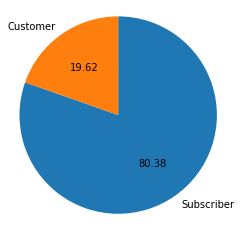

In [14]:
data = df_trips.user_type.value_counts()
plt.pie(data, labels = data.index, startangle=90, counterclock=False, autopct='%.2f');
plt.axis('square');

In [15]:
# Most frequent roats

This histogram shows we have drips with long durations (More than 5 hours) which are not logical.

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [16]:
with open('auth', 'r') as file:
    key = file.read().replace('\n', '')
gmaps.configure(api_key=key)

In [17]:
#markers = gmaps.marker_layer(df_stations[['start_station_latitude','start_station_longitude']])
markers = gmaps.symbol_layer(df_stations[['latitude','longitude']], fill_color='blue', stroke_color='blue',scale=2,fill_opacity=0.5 )
fig = gmaps.figure(center=(37.65158, -122.333234), zoom_level=10, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

In [18]:
#San Francisco
markers = gmaps.marker_layer(df_stations.query('city=="San Francisco"')[['latitude','longitude']])
#markers = gmaps.symbol_layer(df_stations[['latitude','longitude']], fill_color='blue', stroke_color='blue',scale=2)
fig = gmaps.figure(center=(37.77498, -122.419234), zoom_level=13.3, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

In [19]:
#Oakland
markers = gmaps.marker_layer(df_stations.query('city == "Oakland"')[['latitude','longitude']])
#markers = gmaps.symbol_layer(df_stations[['latitude','longitude']], fill_color='blue', stroke_color='blue',scale=2)
fig = gmaps.figure(center=(37.82448, -122.271234), zoom_level=12.5, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

In [20]:
# San Jose
markers = gmaps.marker_layer(df_stations.query('city == "San Jose"')[['latitude','longitude']])
#markers = gmaps.symbol_layer(df_stations[['latitude','longitude']], fill_color='blue', stroke_color='blue',scale=2)
fig = gmaps.figure(center=(37.34058, -121.890234), zoom_level=13.3, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

In [23]:
df = df_stations.merge(df_trips, how='inner',left_on='station_id', right_on='start_station_id' ).merge(df_stations, how='inner',left_on='end_station_id', right_on='station_id' )
df_outOfCityTrips = df[df['city_x'] != df['city_y']]

In [120]:
city_trips = df_outOfCityTrips.groupby(['city_x', 'city_y','start_station_id', 'end_station_id']).size().reset_index()
city_trips.columns = ['city_x', 'city_y','start_station_id', 'end_station_id', 'count']
city_trips

,city_x,city_y,start_station_id,end_station_id,count
0,Oakland,San Francisco,7,12,1
1,Oakland,San Francisco,7,23,1
2,Oakland,San Francisco,7,47,1
3,Oakland,San Francisco,153,22,1
4,Oakland,San Francisco,155,22,2
...,...,...,...,...,...
77,San Francisco,San Jose,63,314,1
78,San Francisco,San Jose,72,395,1
79,San Francisco,San Jose,408,408,78
80,San Jose,San Francisco,305,72,1


### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!